In [3]:
import pandas as pd
import numpy as np
import random

from sklearn.cross_validation import train_test_split

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import sklearn.metrics as skm

import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def find_date_1990(week_from_one):
    
    day7 = timedelta(days=7)
    day6 = timedelta(days=6)
    date_slected = datetime.date(1990,1,7)
    all_date =[date_slected]
    all_date_last = [date_slected + day6]
    for i in range(5200):
        date_slected = date_slected + day7
        all_date.append(date_slected)
        all_date_last.append(date_slected +day6)

    week_Date = pd.DataFrame()
    week_Date['firstData'] = all_date
    week_Date['lastData'] = all_date_last
    week_Date['week'] = range(1,5202)
        
    index_date = week_from_one - 2
    
    return str(all_date[index_date]) + ' ~ ' + str(all_date_last[index_date])

In [5]:
def plot_hist_sent(table, week, Song_name, artist, file_path ='test.png'):
    sentiment = table['sent_score'][table['week_from_one']== week]
    plt.figure(figsize = (16,10)) 
    plt.hist(sentiment, bins = 20, facecolor='g', alpha=0.75)
    titlename = "{} by {} over {}".format(Song_name, artist,find_date_1990(week))
    plt.title (titlename, fontsize = 25)
    plt.xlabel('sentiment polarity score', fontsize = 25)
    plt.savefig(file_path)
    plt.show()

In [6]:
def separate_data(data):
    
    df = data[(data['next_rank'] < 101) & (data['next_rank'] > 0) & (data['current_rank'] < 101)]
    
    df0 = df[df['past_rank_1']>100]
    df1 = df[df['past_rank_1'] <=100]
    
    df1_only = df1[df1['past_rank_2']>100]
    df2 = df1[df1['past_rank_2'] <=100]
    
    df2_only = df2[df2['past_rank_3']>100]
    df3 = df2[df2['past_rank_3'] <=100]
    
    df3_only = df3[df3['past_rank_4']>100]
    df4 = df3[df3['past_rank_4'] <=100]
    
    return df, df0, df1, df1_only, df2, df2_only, df3, df3_only, df4 

In [7]:
def get_dataForAnalysis_reg(df):
    df = df.drop("Unnamed: 0", axis = 1)
    df['twitter_per_hour_log'] = np.log(df['twitter_per_hour'])
    #col = ['twitter_per_hour_log', 'pos_rate', 'neg_rate', 'ratio_pos_neg', 'favorite_rate', 'current_rank', 'diff']
    col = ['twitter_per_hour_log', 'pos_rate', 'neg_rate', 'ratio_pos_neg', 'favorite_rate', 'est', 'next_rank']
    
    return df[col]

# Sentiment Analysis with one example

In [ ]:
df_raw_data_csv = pd.read_csv('../data/result_raw__database34_20160430.csv')

In [107]:
song_id = '7 Years%LUKAS GRAHAM'
week = 1373

In [108]:
sample = df_raw_data_csv[(df_raw_data_csv['Song_ID']== song_id) & (df_raw_data_csv['week_from_one']== week)]
a1,a2,a3 = sum(sample['pos'].values), sum(sample['neu'].values), sum(sample['neg'].values)
a123 = a1 + a2 + a3
print len(sample)
print (a1,a2,a3)
print a1/a123, a2/a123, a3/a123

13329
(3340.0, 9771.0, 218.0)
0.250581438968 0.733063245555 0.0163553154775


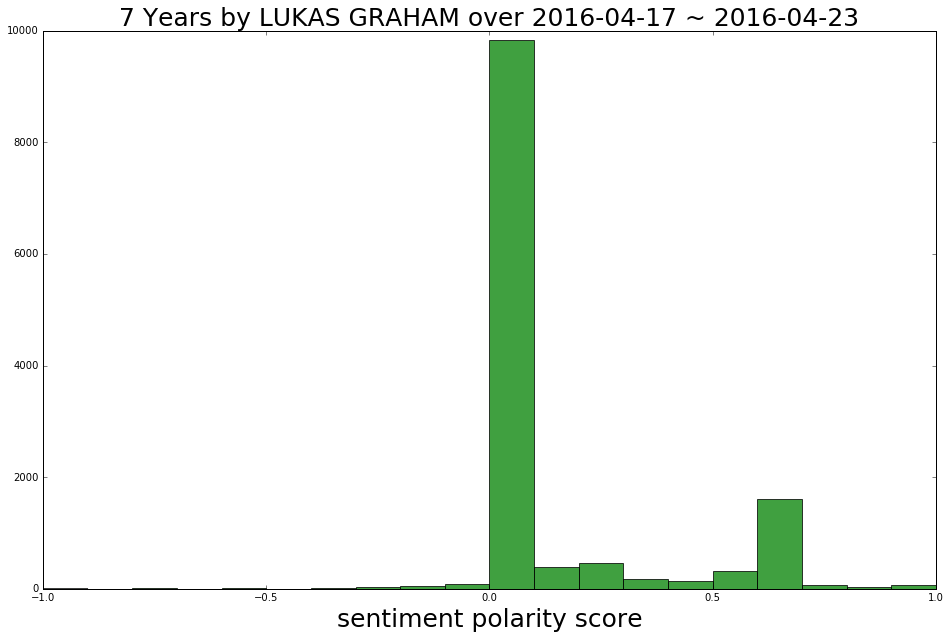

In [112]:
Song_name =song_id.split('%')[0]
artist = song_id.split('%')[1]
table = df_raw_data_csv[df_raw_data_csv['Song_ID']== song_id]
file_path_name = "sentiment_example_1.png"
plot_hist_sent(table, week, Song_name, artist, file_path = file_path_name)

# load data

In [8]:
data_twitter_reg = pd.read_csv('../data/data_twitter_reg.csv')
df_reg = get_dataForAnalysis_reg(data_twitter_reg)

In [9]:
X = df_reg.copy()
y = X.pop('next_rank').values
X_train, X_test, y_train, y_test = train_test_split(X.values, y)

# Random Forest Modeling

## N-estimator tuning

In [10]:
def estimators():
    score_list = []
    for x in xrange(5, 500, 5):
        RFC = RandomForestRegressor(n_estimators=x)
        RFC.fit(X_train, y_train)
        score = RFC.score(X_test, y_test)
        score_list.append(score)
    return score_list

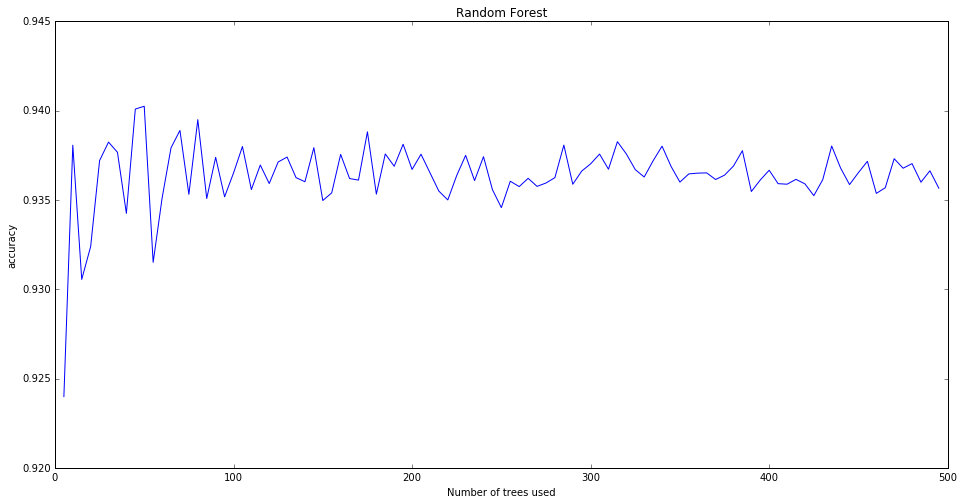

In [11]:
score_list = estimators()
plt.figure(figsize=(16,8))
plt.plot(xrange(5, 500, 5), score_list)
#plt.ylabel('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Number of trees used')
plt.title('Random Forest')
plt.savefig('../data/RandomForestSim_01.png')
plt.show()

## feature importance

In [156]:
RFC = RandomForestRegressor(oob_score=True, n_estimators=500)
RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_test)
print "Accuracy : {}".format(RFC.score(X_test, y_test))
print "Accuracy_out_of_bag: {}".format(RFC.oob_score_)

RandomForestClassifier
Accuracy : 0.885100374082
Accuracy_out_of_bag: 0.891505910955


In [165]:
importances = RFC.feature_importances_
Imp_table2 = pd.DataFrame(columns=['feature','importance'])
Imp_table2['feature'] = list(df_reg.columns[:-1])
Imp_table2['importance'] = list(importances)
Imp_table2['importance'] = Imp_table2['importance']*100
Imp_table = Imp_table2.sort(['importance'], ascending=[1])
Imp_table_twitter = Imp_table[:5]
Imp_table

/Users/Yeongcheon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,feature,importance
2,neg_rate,0.253907
3,ratio_pos_neg,0.299256
1,pos_rate,0.312796
0,twitter_per_hour_log,0.561607
4,favorite_rate,0.611240
5,est,97.961194


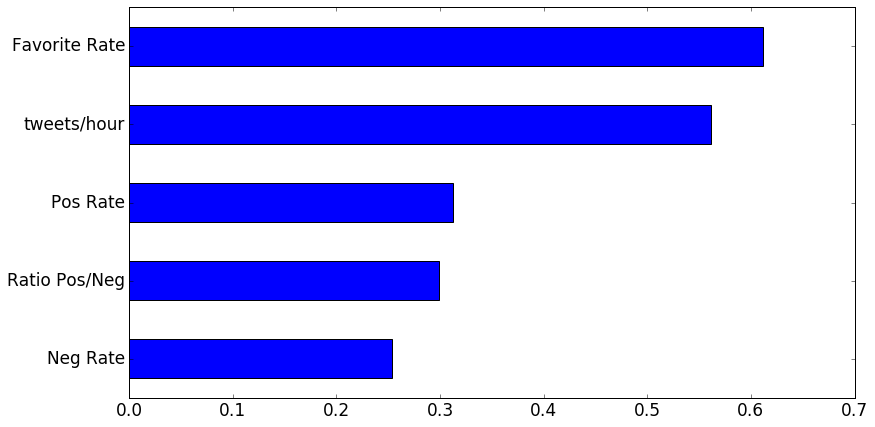

In [166]:
Col_Name = [ "Neg Rate", "Ratio Pos/Neg", "Pos Rate", "tweets/hour", "Favorite Rate"]
Imp_table_twitter.index = Col_Name
#Imp_table.index = Imp_table['feature']
Imp_table_twitter['importance'].plot(kind='barh', figsize=(13, 7), rot=0, fontsize=17 , layout = "rows")
plt.savefig('../data/Important_feature_03.png')
plt.show()

## K-fold cross validation

In [149]:
from sklearn.cross_validation import KFold
num_kfold = 5
kf = KFold(X.shape[0], num_kfold, shuffle=True)

list_RF_r2 = []

for train_index, test_index in kf:
    X_train = X.values[train_index]
    X_test = X.values[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    RFC = RandomForestRegressor(oob_score=True, n_estimators=100)
    RFC.fit(X_train, y_train)
    list_RF_r2.append(RFC.score(X_test, y_test))


In [150]:
np.mean(list_RF_r2)

0.87582335239494946